In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numba import jit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

extract_path = '../img_align_celeba/img_align_celeba'

1. Загрузка и обработка датасета

In [3]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = CelebADataset(root_dir=extract_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(len(dataset))

7566


Функция инициализации весов

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Задание 1

1. Определение архитектуры GAN

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


2. Обучение GAN

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 50
real_label = 1.
fake_label = 0.
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
# fixed_noise = torch.tensor(generate_noise(64, 100))

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ## Update Discriminator with real and fake images
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # noise = torch.tensor(generate_noise(b_size, 100))
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ## Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1} / {D_G_z2}')

    # Save fake images
    fake_images = netG(fixed_noise).detach().cpu()
    utils.save_image(fake_images, f'output_gan/fake_samples_epoch_{epoch}.png', normalize=True)

torch.save(netG.state_dict(), f'models/generator.pth')
torch.save(netD.state_dict(), f'models/discriminator.pth')

[0/1][0/237] Loss_D: 1.7756352424621582 Loss_G: 3.194214344024658 D(x): 0.3644159138202667 D(G(z)): 0.3609389364719391 / 0.04581916332244873
[0/1][1/237] Loss_D: 1.4832684993743896 Loss_G: 5.659152507781982 D(x): 0.9708693027496338 D(G(z)): 0.6904957890510559 / 0.00540908332914114
[0/1][2/237] Loss_D: 0.5313403606414795 Loss_G: 6.350163459777832 D(x): 0.9331458210945129 D(G(z)): 0.29441601037979126 / 0.0021218513138592243
[0/1][3/237] Loss_D: 0.34588414430618286 Loss_G: 5.6368021965026855 D(x): 0.8734341859817505 D(G(z)): 0.1292652189731598 / 0.00414012186229229
[0/1][4/237] Loss_D: 0.3873147964477539 Loss_G: 5.86868953704834 D(x): 0.9217202067375183 D(G(z)): 0.21081684529781342 / 0.003296178299933672
[0/1][5/237] Loss_D: 0.36938363313674927 Loss_G: 6.449512004852295 D(x): 0.9179757833480835 D(G(z)): 0.18629273772239685 / 0.001752160838805139
[0/1][6/237] Loss_D: 0.40576183795928955 Loss_G: 7.909430027008057 D(x): 0.9532679319381714 D(G(z)): 0.2739088535308838 / 0.0004867852258030325
[

3. Загрузка моделей и вывод результатов

In [8]:
def load_model(generator_path, discriminator_path, device):
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    netG.load_state_dict(torch.load(generator_path, map_location=device))
    netD.load_state_dict(torch.load(discriminator_path, map_location=device))
    return netG, netD

# Example of loading the models
generator_path = 'models/generator.pth'
discriminator_path = 'models/discriminator.pth'
netG, netD = load_model(generator_path, discriminator_path, device)


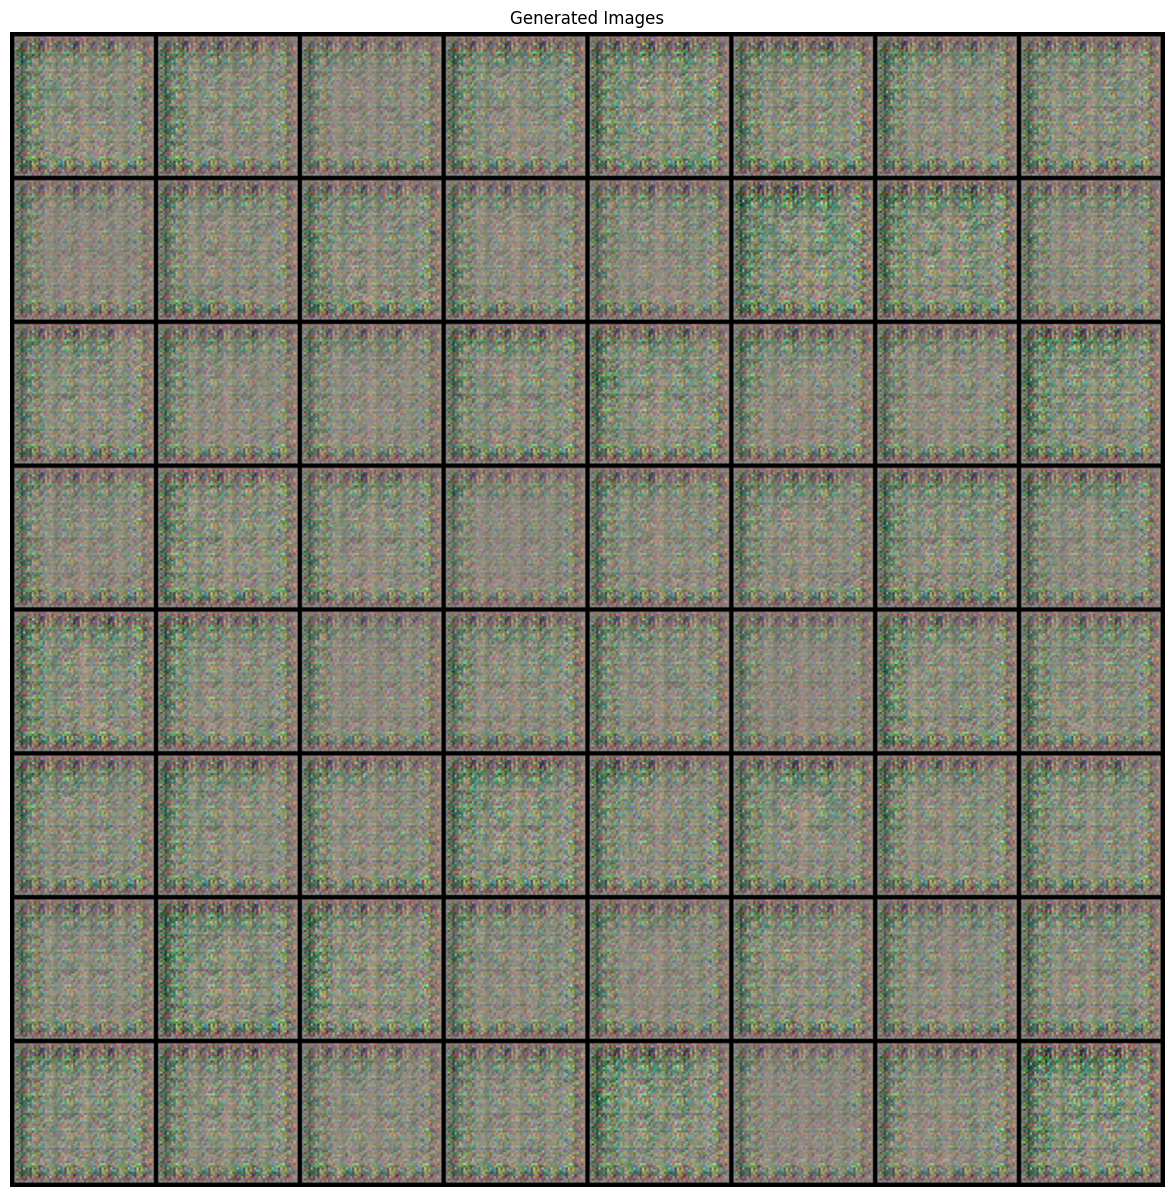

In [9]:
# Generate new images using the loaded model
noise = torch.randn(64, 100, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(utils.make_grid(fake_images, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

# Задание 2

1. Определение cGAN

In [ ]:
class C_Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes):
        super(C_Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz * 2, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_emb = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((noise, label_emb), 1)
        return self.main(input)

class C_Discriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes):
        super(C_Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 64 * 64)
        self.main = nn.Sequential(
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_emb = self.label_emb(labels).view(labels.size(0), 1, 64, 64)
        d_in = torch.cat((img, label_emb), 1)
        return self.main(d_in)


2. Обучение cGAN

In [9]:
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of classes for the labels
num_classes = 2  # Example for simplicity (e.g., smiling, not smiling)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the generator and discriminator
netG = C_Generator(nz, ngf, nc, num_classes).to(device)
netD = C_Discriminator(nc, ndf, num_classes).to(device)

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for generating images
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator with real images
        netD.zero_grad()
        real_images = data.to(device)
        b_size = real_images.size(0)
        real_labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        labels = torch.randint(0, num_classes, (b_size,), device=device)
        output = netD(real_images, labels).view(-1)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device)
        fake_images = netG(noise, fake_labels)
        fake_output = netD(fake_images.detach(), fake_labels).view(-1)
        errD_fake = criterion(fake_output, torch.full((b_size,), fake_label, dtype=torch.float, device=device))
        errD_fake.backward()
        D_G_z1 = fake_output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        output = netD(fake_images, fake_labels).view(-1)
        errG = criterion(output, torch.full((b_size,), real_label, dtype=torch.float, device=device))
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1} / {D_G_z2}')

    # Save fake images
    fake_images = netG(fixed_noise, fixed_labels).detach().cpu()
    utils.save_image(fake_images, f'output_cgan/fake_samples_epoch_{epoch}.png', normalize=True)

torch.save(netG.state_dict(), f'models/c_generator.pth')
torch.save(netD.state_dict(), f'models/c_discriminator.pth')


[0/10][0/63] Loss_D: 1.606764793395996 Loss_G: 13.143416404724121 D(x): 0.5157830715179443 D(G(z)): 0.5781086683273315 / 3.5450186260277405e-05
[0/10][50/63] Loss_D: 0.9907726049423218 Loss_G: 8.842203140258789 D(x): 0.7970592379570007 D(G(z)): 0.1469464898109436 / 0.00019414574489928782
[1/10][0/63] Loss_D: 1.0275448560714722 Loss_G: 14.782527923583984 D(x): 0.9713506698608398 D(G(z)): 0.6087398529052734 / 4.1724771904227964e-07
[1/10][50/63] Loss_D: 0.669815182685852 Loss_G: 3.613138198852539 D(x): 0.725218653678894 D(G(z)): 0.04849828779697418 / 0.03698737919330597
[2/10][0/63] Loss_D: 0.2384912669658661 Loss_G: 4.23184061050415 D(x): 0.9113133549690247 D(G(z)): 0.050845056772232056 / 0.02524307742714882
[2/10][50/63] Loss_D: 0.3073006272315979 Loss_G: 8.045427322387695 D(x): 0.8487801551818848 D(G(z)): 0.024564433842897415 / 0.0009751155157573521
[3/10][0/63] Loss_D: 0.7572707533836365 Loss_G: 7.720873832702637 D(x): 0.7436662316322327 D(G(z)): 0.1062069982290268 / 0.00535952439531

3. Загрузка модели и вывод результатов

In [ ]:
def load_model(generator_path, discriminator_path, device):
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    netG.load_state_dict(torch.load(generator_path, map_location=device))
    netD.load_state_dict(torch.load(discriminator_path, map_location=device))
    return netG, netD

# Example of loading the models
generator_path = 'models/c_generator.pth'
discriminator_path = 'models/c_discriminator.pth'
netG, netD = load_model(generator_path, discriminator_path, device)

In [ ]:
# Generate new images using the loaded model
noise = torch.randn(64, 100, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(utils.make_grid(fake_images, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()